In [1]:
from PIL import Image

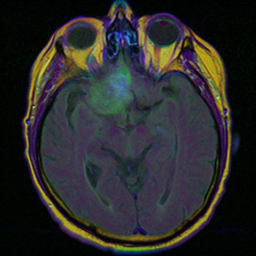

In [13]:
Image.open('data/input/image/TCGA_CS_4941_19960909_11.tif')

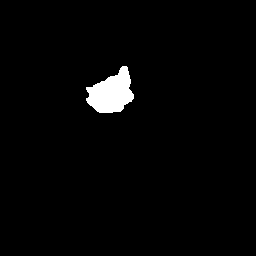

In [5]:
Image.open('data/input/label/TCGA_CS_4941_19960909_11_mask.tif')

In [11]:
[Image.open('data/input/label/TCGA_CS_4941_19960909_'+str(i)+'_mask.tif').show() for i in range(1,24)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

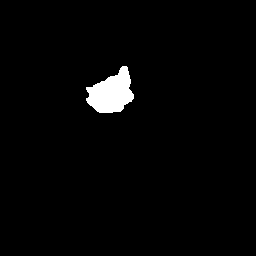

In [5]:
Image.open('data/input/label/TCGA_CS_4941_19960909_11_mask.tif')

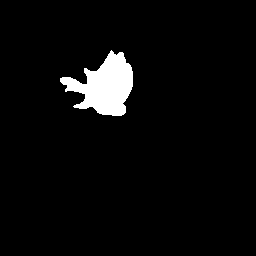

In [6]:
Image.open('data/input/label/TCGA_CS_4941_19960909_12_mask.tif')

In [58]:
a=np.array(Image.open('data/input/label/TCGA_CS_4941_19960909_12_mask.tif').convert("L"))

In [59]:
a.shape

(256, 256)

In [65]:
torch.from_numpy(np.array(a == np.unique(a)[:,None,None],dtype=np.uint8))

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [38]:
import cv2

In [48]:
img_mask = cv2.imread('data/input/label/TCGA_CS_4941_19960909_13_mask.tif').convert("L")

AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [41]:
img_mask.shape

(256, 256, 3)

In [3]:
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

ValueError: illegal image mode

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('data/input/dev.csv')

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd

In [4]:

#from flyai.processor.download import check_download

from path import DATA_PATH

In [5]:
DATA_PATH

'/mnt/Hdd/Proj/github/flyai/vision/MRISegmentation_FlyAI/data/input'

In [63]:
class MRIDataset(Dataset):
    def __init__(self,root,df,transforms = None):
        self.root = root
        self.df = df
        self.transforms = transforms
        self.imgs = df.image_path
        self.masks = df.label_path
    
    def __getitem__(self,idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)
        #print(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        #print(masks)
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)
        masks = torch.from_numpy(np.array(masks,dtype=np.uint8))

        image_id = torch.tensor([idx])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [64]:
ds = MRIDataset(DATA_PATH,df,get_transform(True))

In [65]:
dl = DataLoader(ds,batch_size=2)

In [60]:
a=next(iter(dl))

In [61]:
a[1]['masks']

tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]],


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]], dtype=torch.uint8)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [38]:
img, _ = ds[0]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[]


In [49]:
model.eval()
prediction=model([img.to(device)])

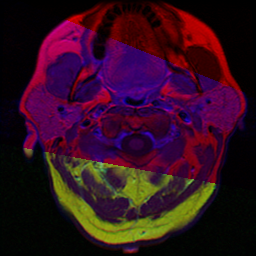

In [48]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

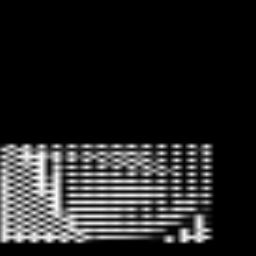

In [50]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [74]:
import torchvision

In [75]:
torchvision.__version__

'0.2.2'

In [ ]:
%%sh

In [12]:
%%sh

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [15]:
#from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/changebio/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 178090079/178090079 [01:42<00:00, 1732000.26it/s]


In [68]:
from engine import train_one_epoch, evaluate

In [69]:
# use our dataset and defined transformations
dataset = MRIDataset(DATA_PATH,df, get_transform(train=True))
dataset_test = MRIDataset(DATA_PATH,df, get_transform(train=False))


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [70]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:00:40  lr: 0.000107  loss: 4.2108 (4.2108)  loss_classifier: 0.6522 (0.6522)  loss_box_reg: 0.0776 (0.0776)  loss_mask: 3.4519 (3.4519)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0288 (0.0288)  time: 0.8172  data: 0.2333  max mem: 4067
Epoch: [0]  [10/50]  eta: 0:00:12  lr: 0.001126  loss: 2.2306 (2.1598)  loss_classifier: 0.3129 (0.3507)  loss_box_reg: 0.0822 (0.0864)  loss_mask: 1.5289 (1.6742)  loss_objectness: 0.0226 (0.0248)  loss_rpn_box_reg: 0.0229 (0.0237)  time: 0.3027  data: 0.0261  max mem: 4702
Epoch: [0]  [20/50]  eta: 0:00:08  lr: 0.002146  loss: 0.7999 (1.6133)  loss_classifier: 0.1090 (0.2288)  loss_box_reg: 0.0619 (0.0749)  loss_mask: 0.5483 (1.2569)  loss_objectness: 0.0228 (0.0255)  loss_rpn_box_reg: 0.0268 (0.0273)  time: 0.2494  data: 0.0049  max mem: 4702
Epoch: [0]  [30/50]  eta: 0:00:05  lr: 0.003165  loss: 0.5088 (1.2642)  loss_classifier: 0.0668 (0.1812)  loss_box_reg: 0.0515 (0.0698)  loss_mask: 0.3468 (0.9593)  loss_ob

Epoch: [2]  [ 0/50]  eta: 0:00:19  lr: 0.005000  loss: 0.0848 (0.0848)  loss_classifier: 0.0138 (0.0138)  loss_box_reg: 0.0298 (0.0298)  loss_mask: 0.0191 (0.0191)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 0.3890  data: 0.1497  max mem: 4717
Epoch: [2]  [10/50]  eta: 0:00:10  lr: 0.005000  loss: 0.3574 (0.3078)  loss_classifier: 0.0459 (0.0405)  loss_box_reg: 0.0557 (0.0609)  loss_mask: 0.2183 (0.1817)  loss_objectness: 0.0110 (0.0120)  loss_rpn_box_reg: 0.0104 (0.0127)  time: 0.2646  data: 0.0171  max mem: 4738
Epoch: [2]  [20/50]  eta: 0:00:07  lr: 0.005000  loss: 0.3433 (0.2826)  loss_classifier: 0.0375 (0.0427)  loss_box_reg: 0.0527 (0.0526)  loss_mask: 0.2149 (0.1650)  loss_objectness: 0.0075 (0.0102)  loss_rpn_box_reg: 0.0110 (0.0122)  time: 0.2506  data: 0.0040  max mem: 4738
Epoch: [2]  [30/50]  eta: 0:00:05  lr: 0.005000  loss: 0.2166 (0.2752)  loss_classifier: 0.0334 (0.0385)  loss_box_reg: 0.0348 (0.0473)  loss_mask: 0.1425 (0.1692)  loss_ob

Epoch: [4]  [ 0/50]  eta: 0:00:20  lr: 0.000500  loss: 0.2541 (0.2541)  loss_classifier: 0.0348 (0.0348)  loss_box_reg: 0.0372 (0.0372)  loss_mask: 0.1667 (0.1667)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 0.4136  data: 0.1529  max mem: 4738
Epoch: [4]  [10/50]  eta: 0:00:10  lr: 0.000500  loss: 0.1885 (0.1552)  loss_classifier: 0.0204 (0.0220)  loss_box_reg: 0.0265 (0.0243)  loss_mask: 0.1257 (0.0959)  loss_objectness: 0.0022 (0.0053)  loss_rpn_box_reg: 0.0075 (0.0077)  time: 0.2646  data: 0.0162  max mem: 4746
Epoch: [4]  [20/50]  eta: 0:00:07  lr: 0.000500  loss: 0.1464 (0.1462)  loss_classifier: 0.0200 (0.0214)  loss_box_reg: 0.0232 (0.0223)  loss_mask: 0.0914 (0.0890)  loss_objectness: 0.0021 (0.0059)  loss_rpn_box_reg: 0.0071 (0.0077)  time: 0.2503  data: 0.0032  max mem: 4746
Epoch: [4]  [30/50]  eta: 0:00:05  lr: 0.000500  loss: 0.1400 (0.1506)  loss_classifier: 0.0202 (0.0241)  loss_box_reg: 0.0200 (0.0239)  loss_mask: 0.0914 (0.0894)  loss_ob

Epoch: [6]  [ 0/50]  eta: 0:00:19  lr: 0.000050  loss: 0.0226 (0.0226)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0067 (0.0067)  loss_mask: 0.0005 (0.0005)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 0.3973  data: 0.1575  max mem: 4746
Epoch: [6]  [10/50]  eta: 0:00:10  lr: 0.000050  loss: 0.0226 (0.0932)  loss_classifier: 0.0084 (0.0187)  loss_box_reg: 0.0067 (0.0134)  loss_mask: 0.0033 (0.0531)  loss_objectness: 0.0015 (0.0025)  loss_rpn_box_reg: 0.0061 (0.0056)  time: 0.2616  data: 0.0168  max mem: 4746
Epoch: [6]  [20/50]  eta: 0:00:07  lr: 0.000050  loss: 0.1294 (0.1209)  loss_classifier: 0.0174 (0.0201)  loss_box_reg: 0.0147 (0.0181)  loss_mask: 0.0879 (0.0727)  loss_objectness: 0.0016 (0.0035)  loss_rpn_box_reg: 0.0068 (0.0064)  time: 0.2490  data: 0.0033  max mem: 4746
Epoch: [6]  [30/50]  eta: 0:00:05  lr: 0.000050  loss: 0.1887 (0.1345)  loss_classifier: 0.0195 (0.0208)  loss_box_reg: 0.0208 (0.0200)  loss_mask: 0.1226 (0.0834)  loss_ob

Epoch: [8]  [ 0/50]  eta: 0:00:21  lr: 0.000050  loss: 0.1446 (0.1446)  loss_classifier: 0.0190 (0.0190)  loss_box_reg: 0.0221 (0.0221)  loss_mask: 0.0932 (0.0932)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 0.4304  data: 0.1670  max mem: 4746
Epoch: [8]  [10/50]  eta: 0:00:10  lr: 0.000050  loss: 0.1026 (0.1022)  loss_classifier: 0.0148 (0.0151)  loss_box_reg: 0.0108 (0.0160)  loss_mask: 0.0688 (0.0601)  loss_objectness: 0.0030 (0.0046)  loss_rpn_box_reg: 0.0060 (0.0064)  time: 0.2672  data: 0.0173  max mem: 4746
Epoch: [8]  [20/50]  eta: 0:00:07  lr: 0.000050  loss: 0.0304 (0.1047)  loss_classifier: 0.0145 (0.0150)  loss_box_reg: 0.0057 (0.0157)  loss_mask: 0.0037 (0.0645)  loss_objectness: 0.0016 (0.0034)  loss_rpn_box_reg: 0.0056 (0.0061)  time: 0.2503  data: 0.0031  max mem: 4746
Epoch: [8]  [30/50]  eta: 0:00:05  lr: 0.000050  loss: 0.1336 (0.1121)  loss_classifier: 0.0163 (0.0161)  loss_box_reg: 0.0165 (0.0160)  loss_mask: 0.0834 (0.0704)  loss_ob

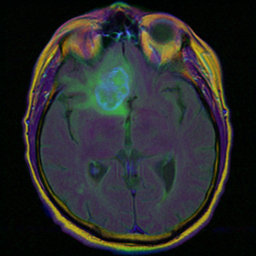

In [77]:
# pick one image from the test set
img, _ = dataset_test[11]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())


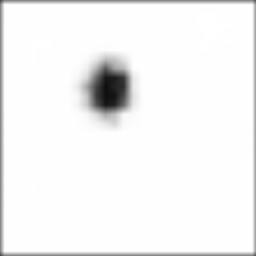

In [78]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.BATCH, sampler=sampler, **kwargs)
    test_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=args.BATCH, **kwargs)
    n_train = len(train_dataset)
    batch_train = n_train/args.BATCH
    print(args.BATCH,n_train/args.BATCH)
    n_test = len(val_dataset)
    batch_test = n_test/args.BATCH
    print("2. load data. train_dataset %d,batch %d, val_dataset %d, batch %d." % (n_train,batch_train,n_test,batch_test))
  
    #load net structure
    print("3.load net structure: %s, number of class: %d" % (settings.net,settings.nc))
    net = VGG(settings.net,settings.nc,settings.sigmoid)
    #net = pretrained_net(settings.net,settings.nc)
    gpu = torch.cuda.is_available()
    if gpu:
        net.cuda()
    #optimize and loss
    print("4.optimize and loss. learning rate %g" % settings.lr)
    optimizer = Adam(net.parameters(), lr=settings.lr, betas=(0.9, 0.999)) 
    #optimizer = Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))  
    loss_fn = nn.CrossEntropyLoss()

    #train and test
    print("5.***************train and test*********************")
    best_accuracy = 0
    train_iter = iter(train_loader)
    batch_idx = 0
    losses=[]
    for i in range(args.EPOCHS):
        net.train()
        #x_train, y_train, x_test, y_test = data.next_batch(args.BATCH) 
        #x_train = torch.from_numpy(x_train)
        #y_train = torch.from_numpy(y_train)
        #x_train = x_train.float()
        try:
            batch_idx +=1
            x_train, y_train = next(train_iter)
            #y_train = y_train.float()
            #print(batch_idx,"data len",x_train.shape,y_train.shape)
        except:
            sampler = torch.utils.data.sampler.WeightedRandomSampler(weight, len(weight))
            train_loader = torch.utils.data.DataLoader(train_dataset,
                batch_size=args.BATCH, sampler=sampler, **kwargs)
            batch_idx = 0
            train_iter = iter(train_loader)
            x_train, y_train = next(train_iter)
            #y_train = y_train.float()
            print(len(x_train),len(y_train),"next circle")

        if gpu:
            x_train = Variable(x_train.cuda())
            y_train = Variable(y_train.cuda())
       

        outputs = net(x_train)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % settings.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(x_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        